In [25]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

In [29]:
# Define constants, but we do it as a class (to later make passing it around easier)

class Const:
    def __init__(self):
        self.n_animals_max = 1000
        self.n_animals_start = 20  # Original n_animals
        self.n_steps = 400
        self.vmin = 0.01
        self.vmax = 0.05
        self.v_decay = 0.4 # <--------------- To make movement more realistic
        
        self.hp_baby = 10
        self.hp_food = 5
        self.hp_reproduction = 40
        self.hp_birthcost = 7
        self.hp_leak = 0.5
        
        self.food_rate = 1
        self.eating_distance = 0.05
        self.n_food_max = 1000
        self.n_food_start = 100

In [34]:
# Build the model
def model(c, show_dotses=False, n_trials=1):
    history = np.zeros((c.n_steps, n_trials))

    for i_trial in range(n_trials):
        # Allocate hp for all animals, but only first few are alive
        hp = np.zeros(c.n_animals_max)
        hp[:c.n_animals_start] = np.random.uniform(
            low=c.hp_baby, high=c.hp_reproduction, size=c.n_animals_start)
        
        x = np.random.uniform(size=c.n_animals_max)
        y = np.random.uniform(size=c.n_animals_max)
        vx = np.random.uniform(size=c.n_animals_max, low=c.vmin, high=c.vmax)*(
            2*np.random.randint(size=c.n_animals_max,low=0,high=2) - 1)
        vy = np.random.uniform(size=c.n_animals_max, low=c.vmin, high=c.vmax)*(
            2*np.random.randint(size=c.n_animals_max,low=0,high=2) - 1)
        
        # Let there be cabbage!
        foodx = np.ones(c.n_food_max)*-1
        foodx[:c.n_food_start] = np.random.uniform(size=c.n_food_start)
        foody = np.random.uniform(size=c.n_food_max) 
        # Y doen't matter coz x=-1 is enough to move cabbage out of this world
        
        n_animals = np.zeros(c.n_steps)

        if show_dotses: # Init plots
            fig = plt.figure(figsize=(3,3))
            ax = plt.subplot(111) # No subplots; just creating axes
            plt.xlim((0,1));
            plt.ylim((0,1));
            fig.show()
            fig.canvas.draw()

        for t in range(c.n_steps):
            x += vx
            y += vy
            
            vx = vx*c.v_decay + np.random.randn(c.n_animals_max)*c.vmin 
            vy = vy*c.v_decay + np.random.randn(c.n_animals_max)*c.vmin
            # ^^^-------------- Make them run around (keeps speed somewhat randomized)

            # Reflect from the walls
            vx = np.where(np.logical_or(x>1,x<0), -vx , vx)
            vy = np.where(np.logical_or(y>1,y<0), -vy , vy)
            x = np.maximum(0,np.minimum(x,1)) # <------------------- Keep them in enclosure
            y = np.maximum(0,np.minimum(y,1))
            
            #Cabbage eatin' time, my dudes
            for i_animal in range(c.n_animals_max):
                if hp[i_animal]<=0: # Skip dead animals
                    continue
                # Version with a loop:
                for i_food in range(c.n_food_max):
                    if foodx[i_food]<0: # <------------------- This makes things faster
                        continue
                    d = np.sqrt((x[i_animal]-foodx[i_food])**2 + (y[i_animal]-foody[i_food])**2)
                    if d < c.eating_distance:
                        hp[i_animal] += c.hp_food
                        foodx[i_food] = -1
   
            #Numpy version
            #d = np.sqrt((x[i_animal]-foodx)**2 + (y[i_animal]-foody)**2)
            #eaten_food = d < c.eating_distance
            #foodx[eaten_food] = -1
            #hp[i_animal] += c.hp_food*sum(eaten_food)     
            
            # Let there be cabbage!
            potential_cabbage = np.argwhere(foodx<0)
            if potential_cabbage.size != 0:
                foodx[potential_cabbage[0]] = np.random.uniform()
                foody[potential_cabbage[0]] = np.random.uniform()
                
            # Ok... doing same thing for cabbage with babies... cabbage patch kids, if u will
            potential_babies = np.argwhere(c.hp_reproduction > 0)
            if potential_babies.size != 0:
                baby_spawn = np.argwhere(hp <= 0)        
                hp[potential_babies[0]] -= c.hp_birthcost
                x[baby_spawn[0]] = x[potential_babies[0]]
                y[baby_spawn[0]] = y[potential_babies[0]]
                hp[baby_spawn[0]] = c.hp_baby
                
            hp -= c.hp_leak # Death
            
            n_animals[t] = np.sum(hp>0)
            
            if show_dotses: # Actual animation
                ax.clear()
                plt.plot(x[hp>0], y[hp>0], 'k.',markersize=5);
                #plt.plot(x[baby_spawn], y[baby_spawn], 'r.',markersize=5);
                plt.plot(foodx,foody,'g.', markersize=2)
                plt.xlim((0,1));
                plt.ylim((0,1));
                fig.canvas.draw() # Redraws the canvas (key secret command to animate things)
        # --- Time loop is over

        history[:,i_trial] = n_animals
    return np.mean(history, axis=1)

<IPython.core.display.Javascript object>


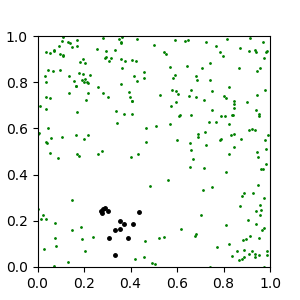

<IPython.core.display.Javascript object>


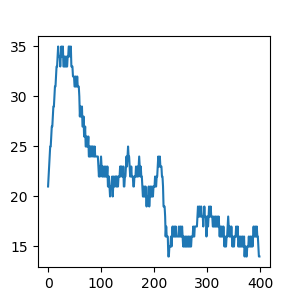

In [35]:
c = Const()
curve = model(c, show_dotses=True);
plt.figure(figsize=(3,3))
plt.plot(curve)